In [3]:
from sklearn.experimental import enable_halving_search_cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split, HalvingGridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import collections
import random
from math import sqrt
import sklearn
import joblib
from joblib import parallel_backend
import copy

In /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Load Data

In [2]:
#load training data
df = pd.read_csv('Input/ogden_viral_selection_AAV2_sequences_VP1.csv')
a_list=df['AA_Sequences'].tolist()
a_list=[str(i) for i in a_list]
a_list.pop(0) #Make sure to account for this in applying selection_wt_norm_AVG. This was to remove the first empty entry 'nan'.

'nan'

In [ ]:
# Here you can provide whatever embeddings you would generate from either a protein language model or some other amino acid representation.
#hvg = get_embeddings(a_list)
#np.savetxt('Input/hvgVP1.txt',hvg,fmt='%s')

In [5]:
X = np.loadtxt('Input/hvgVP1.txt')
df = pd.read_csv('Input/ogden_viral_selection_AAV2_sequences_VP1.csv')
y = df['selection_wt_norm_AVG']
y.pop(0)
print(X.shape, y.shape)

(30844, 1900) (30844,)


### Rebalance Data by Removing Low Fitness Score Sequences from Dataset

In [6]:
random.seed(a=42)
inds= np.digitize(y,[-2.0,-1.5,-1.0,-0.5,0,0.5])
frequency = collections.Counter(inds)
print(dict(frequency))
print(sorted(dict(frequency).items(), key = lambda kv:(kv[1], kv[0])))  
delete_index=[idx for idx, element in enumerate(inds) if element==2 or element==3]
remove_sequence_index=random.sample(delete_index,5095)
print(len(remove_sequence_index))

{3: 8235, 5: 2242, 4: 6525, 2: 8746, 6: 202, 1: 4836, 0: 58}
[(0, 58), (6, 202), (5, 2242), (1, 4836), (4, 6525), (3, 8235), (2, 8746)]
5095


In [9]:
ydel=copy.deepcopy(list(y))
xdel=copy.deepcopy(X)
for index in sorted(remove_sequence_index, reverse=True):
    del ydel[index]
print(len(ydel))
xdel=np.delete(xdel,remove_sequence_index,0)
print(xdel.shape)

25749
(25749, 1900)


### Train / Test Split

In [10]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(xdel, ydel, train_size=train_size, random_state=42)
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((20599, 1900), (5150, 1900), 20599, 5150)

### PCA

In [11]:
pca = PCA(60)
Xs_train_pca = pca.fit_transform(Xs_train)

## Visualize Embeddings

Here, we plot the first two principal components on the x and y axes. Each point is then colored by its scaled effect (what we want to predict).


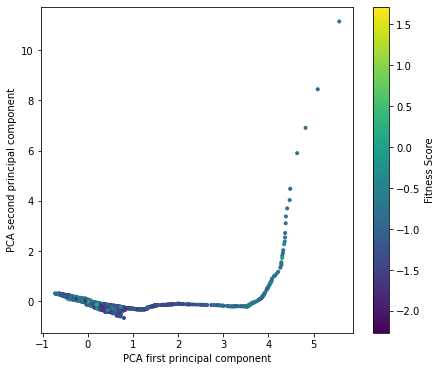

In [12]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Fitness Score')

<a id='grid_search'></a>

## Initialize / Run GridSearch

We will run grid search for four different regression models:
1. [K-nearest-neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
2. [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR)
3. [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforestregressor#sklearn.ensemble.RandomForestRegressor)
4. [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?)

### Initialize grids for different regression techniques

In [13]:
knn_grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [15, 30],
    'p' : [1, 2],
}

svm_grid = {
    'C' : [0.1, 1.0, 10.0],
    'kernel' :['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [3],
    'gamma': ['scale'],
}

rfr_grid = {
    'n_estimators' : [20],
    'criterion' : ['mse', 'mae'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [5, 10],
    'min_samples_leaf': [1, 4]
}
r_grid = {'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [17]:
cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor, Ridge]
param_grid_list = [knn_grid, svm_grid, rfr_grid, r_grid]

### Run Grid Search 


In [18]:
result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = HalvingGridSearchCV(
        estimator = cls_name(), 
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 762
max_resources_: 20599
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 762
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 1
n_candidates: 16
n_resources: 2286
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 2
n_candidates: 6
n_resources: 6858
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 20574
Fitting 5 folds for each of 2 candidates, totalling 10 fits
<class 'sklearn.svm._classes.SVR'>
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2288
max_resources_: 20599
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 2288
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n

<a id='browse'></a>
## Browse the Sweep Results

The following tables show the top 5 parameter settings, based on `mean_test_score`. Given our setup, this should really be thought of as `validation_score`.

### K Nearest Neighbors

In [ ]:
result_list[0].sort_values('rank_test_score')[:5]

### SVM

In [ ]:
result_list[1].sort_values('rank_test_score')[:5]

### Random Forest

In [ ]:
result_list[2].sort_values('rank_test_score')[:5]

## Ridge

In [ ]:
result_list[3].sort_values('rank_test_score')[:5]

<a id='eval'></a>
## Evaluation

Now that we have run grid search, each `grid` object contains a `best_estimator_`.

We can use this to evaluate the correlation between our predictions and the true effect scores on the held-out validation set.

In [19]:
for grid in grid_list:
    print(grid.best_estimator_)
    print()
    preds = grid.predict(Xs_test)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print(f'Pearson Correlation and P-Score: {scipy.stats.pearsonr(ys_test, preds)}')
    print(f'RMSE: {sqrt(sklearn.metrics.mean_squared_error(ys_test, preds))}')
    print('\n', '-' * 80, '\n')


KNeighborsRegressor(algorithm='kd_tree', p=1, weights='distance')

SpearmanrResult(correlation=0.7203753717052244, pvalue=0.0)
Pearson Correlation and P-Score: (0.7232011173597749, 0.0)
RMSE: 0.43101389571347476

 -------------------------------------------------------------------------------- 

SVR(C=10.0, kernel='linear')

SpearmanrResult(correlation=0.5409318990345691, pvalue=0.0)
Pearson Correlation and P-Score: (0.519738224913917, 0.0)
RMSE: 0.52930705337787

 -------------------------------------------------------------------------------- 

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=20)

SpearmanrResult(correlation=0.7194360870199125, pvalue=0.0)
Pearson Correlation and P-Score: (0.7143269458537931, 0.0)
RMSE: 0.44141502527556387

 -------------------------------------------------------------------------------- 

Ridge(solver='svd')

SpearmanrResult(correlation=0.4450542269010905, pvalue=4.365605513482381

In [20]:
KNModel=grid_list[0]
SVModel=grid_list[1]
RFModel=grid_list[2]
RModel=grid_list[3]

In [ ]:
joblib.dump(KNModel, 'Models/AAV_KN_PLM_Model_VP1_Weighted.pkl')
joblib.dump(SVModel, 'Models/AAV_SVM_PLM_Model_VP1_Weighted.pkl')
joblib.dump(RFModel, 'Models/AAV_RF_PLM_Model_VP1_Weighted.pkl')
joblib.dump(RModel, 'Models/AAV_R_PLM_Model_VP1_Weighted.pkl')

In [13]:
KNModel=joblib.load('Models/AAV_KN_PLM_Model_VP1_Weighted.pkl')
SVModel=joblib.load('Models/AAV_SVM_PLM_Model_VP1_Weighted.pkl')
RFModel=joblib.load('Models/AAV_RF_PLM_Model_VP1_Weighted.pkl')
RModel=joblib.load('Models/AAV_R_PLM_Model_VP1_Weighted.pkl')

In [ ]:
preds=KNModel.predict(Xs_test)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(ys_test,preds, s=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Experimental Fitness Score")
ax.set_ylabel("Predicted Fitness Score")
ax.set_title("PLM K-Neighbors Correlation")

In [ ]:
preds=SVModel.predict(Xs_test)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(ys_test,preds, s=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Experimental Fitness Score")
ax.set_ylabel("Predicted Fitness Score")
ax.set_title("PLM SVM Correlation")

In [ ]:
preds=RFModel.predict(Xs_test)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(ys_test,preds, s=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Experimental Fitness Score")
ax.set_ylabel("Predicted Fitness Score")
ax.set_title("PLM Random Forest Correlation")

In [ ]:
preds=RModel.predict(Xs_test)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(ys_test,preds, s=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Experimental Fitness Score")
ax.set_ylabel("Predicted Fitness Score")
ax.set_title("PLM Ridge Correlation")

## One-Hot Model Training

In [18]:
# Adapted from Hsu et al. (2022)
aa_to_int = {
    'M':1,
    'R':2,
    'H':3,
    'K':4,
    'D':5,
    'E':6,
    'S':7,
    'T':8,
    'N':9,
    'Q':10, 'C':11,
    'U':12,
    'G':13,
    'P':14,
    'A':15,
    'V':16,
    'I':17,
    'F':18,
    'Y':19,
    'W':20,
    'L':21,
    'O':22, #Pyrrolysine
    'X':23, # Unknown
    'Z':23, # Glutamic acid or GLutamine
    'B':23, # Asparagine or aspartic acid
    'J':23, # Leucine or isoleucine
    'start':24,
    'stop':25,
    '-':26,
}
def seqs_to_onehot(seqs):
    seqs = format_batch_seqs(seqs)
    X = np.zeros((seqs.shape[0], seqs.shape[1]*24), dtype=int)
    for i in range(seqs.shape[1]):
        for j in range(24):
            X[:, i*24+j] = (seqs[:, i] == j)
    return X
def format_batch_seqs(seqs):
    maxlen = 755
#     for s in seqs:
#         if len(s) > maxlen:
#             maxlen = len(s)
    formatted = []
    for seq in seqs:
        pad_len = maxlen - len(seq)
        padded = np.pad(format_seq(seq), (0, pad_len), 'constant', constant_values=0)
        formatted.append(padded)
    return np.stack(formatted)
def format_seq(seq,stop=False):
    """
    Takes an amino acid sequence, returns a list of integers in the codex of the babbler.
    Here, the default is to strip the stop symbol (stop=False) which would have 
    otherwise been added to the end of the sequence. If you are trying to generate
    a rep, do not include the stop. It is probably best to ignore the stop if you are
    co-tuning the babbler and a top model as well.
    """
    if stop:
        int_seq = aa_seq_to_int(seq.strip())
    else:
        int_seq = aa_seq_to_int(seq.strip())[:-1]
    return int_seq
def aa_seq_to_int(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return [24] + [aa_to_int[a] for a in s] + [25]

In [19]:
a_listdel=copy.deepcopy(a_list)
a_listdel=np.delete(a_listdel,remove_sequence_index,0)
onehot=seqs_to_onehot(a_listdel)
onehot.shape

(25749, 18144)

In [20]:
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(onehot, ydel, train_size=train_size, random_state=42)

In [21]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((20599, 18144), (5150, 18144), 20599, 5150)

The cell below here is used to make modified_y, which is the label used for one-hot training. This modified_y contains information about the error between the prediction on the training set and the actual experimental data.

In [38]:
Model=joblib.load('Models/AAV_RF_PLM_Model_VP1_Weighted.pkl')
trainpreds=Model.predict(Xs_train)
modified_y=np.subtract(y_train,trainpreds)

In [39]:
preds = Model.predict(Xs_test)
print(f'{scipy.stats.spearmanr(ys_test, preds)}')
print(f'Pearson Correlation and P-Score: {scipy.stats.pearsonr(ys_test, preds)}')
print(f'RMSE: {sqrt(sklearn.metrics.mean_squared_error(ys_test, preds))}')
print('\n', '-' * 80, '\n')


SpearmanrResult(correlation=0.7194360870199125, pvalue=0.0)
Pearson Correlation and P-Score: (0.7143269458537931, 0.0)
RMSE: 0.44141502527556387

 -------------------------------------------------------------------------------- 



In [40]:
#Use this to force multi-processing
with parallel_backend('threading', n_jobs=-1):
    cls_list = [RandomForestRegressor]
    param_grid_list = [rfr_grid]
    result_list = []
    grid_list = []
    for cls_name, param_grid in zip(cls_list, param_grid_list):
        print(cls_name)
        grid = HalvingGridSearchCV(
            estimator = cls_name(), 
            param_grid = param_grid,
            scoring = 'r2',
            verbose = 1,
            n_jobs = -1 # use all available cores
        )
        grid.fit(X_train, modified_y)
        result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
        grid_list.append(grid)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2288
max_resources_: 20599
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 16
n_resources: 2288
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 6
n_resources: 6864
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 20592
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [41]:
for grid in grid_list:
    print(grid.best_estimator_)
    print()
    ridgepreds = grid.predict(X_test)
    preds = np.add(ridgepreds, Model.predict(Xs_test))
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print(f'Pearson Correlation and P-Score: {scipy.stats.pearsonr(ys_test, preds)}')
    print(f'RMSE: {sqrt(sklearn.metrics.mean_squared_error(ys_test, preds))}')
    print('\n', '-' * 80, '\n')


RandomForestRegressor(criterion='mae', max_features='log2',
                      min_samples_split=10, n_estimators=20)

SpearmanrResult(correlation=0.8220541236499732, pvalue=0.0)
Pearson Correlation and P-Score: (0.8176850826180919, 0.0)
RMSE: 0.36222456304762296

 -------------------------------------------------------------------------------- 



In [42]:
joblib.dump(grid_list[0], 'Models/AAV_One_Hot_Model-755.pkl')

['AAV_One_Hot_Model-755.pkl']

In [22]:
RidgeModel=joblib.load('Models/AAV_One_Hot_Model-755.pkl')

In [ ]:
preds=RFModel.predict(Xs_test)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(ys_test,preds, s=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Experimental Selection Weight")
ax.set_ylabel("Predicted Selection Weight")
ax.set_title("PLM Random Forest Correlation")

In [ ]:
ridge_preds=RidgeModel.predict(X_test)
better_preds = np.add(ridge_preds,preds)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(ys_test,better_preds, s=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Experimental Selection Weight")
ax.set_ylabel("Predicted Selection Weight")
ax.set_title("PLM Random Forest+One Hot Random Forest Correlation")
plt.show()
